In [1]:
import pandas as pd
import talib
import numpy as np

# Load the data
instrument = "EUR_USD_M15"
df = pd.read_csv(f'/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data/{instrument}_raw_data.csv', 
                 parse_dates=["time"])
df.set_index("time", inplace=True)

# Add time-based features
df["year"] = df.index.year
df["month"] = df.index.month
df["day_of_week"] = df.index.dayofweek
df["hour"] = df.index.hour
df["minute"] = df.index.minute
# Calculate ATR
df["atr"] = talib.ATR(df["high"], df["low"], df["close"], timeperiod=1)
# df["log_close"] = np.log(df["close"])
# df["log_high"] = np.log(df["high"])
# df["log_low"] = np.log(df["low"])
# df["log_atr"] = np.log(df["atr"])

# Remove NaN values
df = df.dropna()

# Extract only year 2018
df = df[df["year"] == 2018]

# Calculate Q1 and Q3
Q1 = df['atr'].quantile(0.4)
Q3 = df['atr'].quantile(0.9)
IQR = Q3 - Q1

# Create the new 'atr_cleaned' column
df['atr_cleaned'] = df['atr'].clip(lower=Q1, upper=Q3)

df

,open,high,low,close,volume,year,month,day_of_week,hour,minute,atr,atr_cleaned
time,,,,,,,,,,,,
2018-01-01 22:00:00+00:00,1.20071,1.20121,1.20044,1.20106,98,2018,1,0,22,0,0.00082,0.00082
2018-01-01 22:15:00+00:00,1.20106,1.20132,1.20059,1.20074,126,2018,1,0,22,15,0.00073,0.00073
2018-01-01 22:30:00+00:00,1.20076,1.20174,1.20076,1.20152,66,2018,1,0,22,30,0.00100,0.00100
2018-01-01 22:45:00+00:00,1.20164,1.20168,1.20143,1.20152,48,2018,1,0,22,45,0.00025,0.00056
2018-01-01 23:00:00+00:00,1.20148,1.20153,1.20019,1.20148,1792,2018,1,0,23,0,0.00134,0.00134
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:45:00+00:00,1.14596,1.14612,1.14559,1.14562,165,2018,12,0,20,45,0.00053,0.00056
2018-12-31 21:00:00+00:00,1.14562,1.14588,1.14562,1.14586,87,2018,12,0,21,0,0.00026,0.00056
2018-12-31 21:15:00+00:00,1.14590,1.14628,1.14581,1.14628,111,2018,12,0,21,15,0.00047,0.00056


Original ATR range: 1.999999999990898e-05 to 0.011299999999999866
Cleaned ATR range: 0.000560000000000116 to 0.0013600000000000279
Q1: 0.000560000000000116
Q3: 0.0013600000000000279


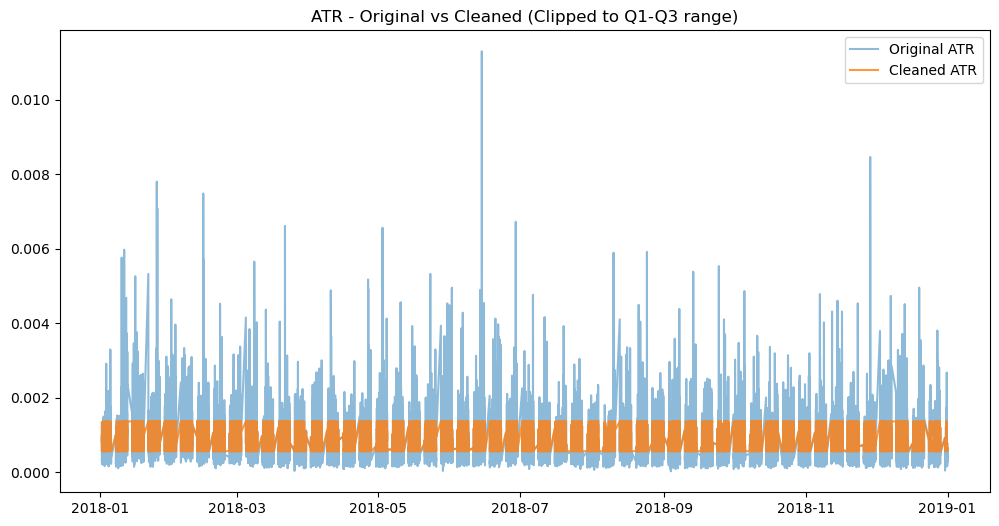

In [2]:
# Print some statistics
print(f"Original ATR range: {df['atr'].min()} to {df['atr'].max()}")
print(f"Cleaned ATR range: {df['atr_cleaned'].min()} to {df['atr_cleaned'].max()}")
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")

# Optional: Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['atr'], label='Original ATR', alpha=0.5)
plt.plot(df.index, df['atr_cleaned'], label='Cleaned ATR', alpha=0.8)
plt.title('ATR - Original vs Cleaned (Clipped to Q1-Q3 range)')
plt.legend()
plt.show()

In [ ]:
# # Load your actual data here
# df = pd.read_csv('/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data/GBP_USD_M15_raw_data.csv', parse_dates=["time"])
# df.set_index("time", inplace=True)
# df = df[df["year"] == 2018]


window_splitter = OrderedSlidingWindowSplitter(train_weeks=4, test_weeks=2, step_size=1)

print(f"Total number of splits: {window_splitter.get_n_splits(df)}")

for window, (train_indices, test_indices) in enumerate(window_splitter.split(df), 1):
    train_data = df.iloc[train_indices]
    test_data = df.iloc[test_indices]
    
    print(f"\nWindow {window}:")
    print(f"Train data: {train_data.index[0]} to {train_data.index[-1]}")
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data: {test_data.index[0]} to {test_data.index[-1]}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Expected train points: {4 * 5 * 24 * 4}, Actual: {len(train_indices)}")
    print(f"Expected test points: {2 * 5 * 24 * 4}, Actual: {len(test_indices)}")
    
    # if window == window_splitter.get_n_splits(df):
    #     break

print("\nAll windows processed.")
